# Daily Forecast Model with Dual Seasonality

In current version, there is no implicit dual seasonal model yet.  To model dual seasonality, we can leverage `fourier series` to model the second seasonality which has longer duration. Also note that here, we are going to demonstrate a `multiplicative` model.  Hence, we will leverage `log` transformation explicitly.

In [1]:
import pandas as pd
import numpy as np
import math
import sys
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from orbit.dlt import DLT
from orbit.dlt import LGT
from orbit.utils.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.simulation import make_trend, make_seasonality
from orbit.utils.utils import fourier_series_df

## Case I - Synthetic Data

We test on a synthetic data with `y(t) = exp(u(t) + s1(t) + s2(t) + noise)` where `s1` as the annual seasonality with cycle=365.25 and `s2` as a weekly cycle.

In [24]:
date_col='ds'
response_col='y'

series_len = 356 * 5
seed = 2020
u = make_trend(series_len=series_len, rw_loc=1e-3, rw_scale=1e-3, type='rw', seed=seed)
s1 =  make_seasonality(series_len=series_len, seasonality=365.25, order=3, scale=1e-1, type='fourier', seed=seed)
s2 =  make_seasonality(series_len=series_len, seasonality=7, duration=1, scale=1e-2, type='discrete', seed=seed)
noise = np.random.default_rng(seed).normal(0, 1e-1, series_len)
obs = np.exp(u + s1 + s2 + noise) * 1000
dt = pd.date_range(start='2010-01-01', periods=series_len, freq="1D")
raw_df=pd.DataFrame({'ds':dt, 'y':obs})

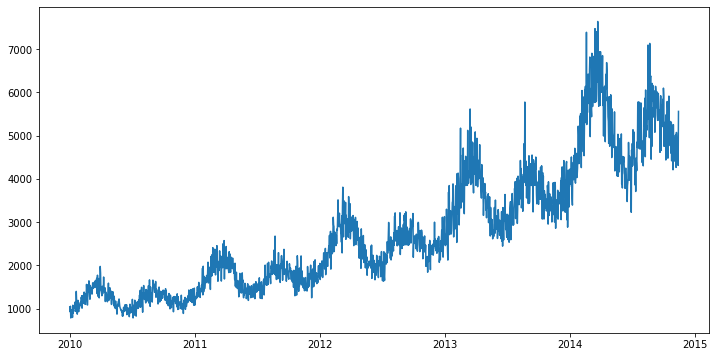

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(raw_df[date_col], raw_df[response_col])

We can model `s1` as harmonic series and let `s2` modeled sesonal smoothing by `DLT`. To do that, we call `fourier_series_df` to generate the harmonic functions and treat them as regressors.

In [26]:
df, fs_cols = fourier_series_df(raw_df, date_col, 365.25, 3)
df['log_y'] = np.log(df[response_col])
df.head(3)

,ds,y,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,log_y
0,2010-01-01,1028.455453,-9.797174e-15,1.000000,-1.959435e-14,1.000000,2.745190e-14,1.000000,6.935813
1,2010-01-02,923.692730,1.720158e-02,0.999852,3.439806e-02,0.999408,5.158437e-02,0.998669,6.828379
2,2010-01-03,1051.843703,3.439806e-02,0.999408,6.875541e-02,0.997634,1.030314e-01,0.994678,6.958300


In [27]:
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

In version `0.7`, we introduce a parameter `period` for `DLT` make time step consistent in different frequncy basis. By default, `period` is set to 1.

In [28]:
mod = DLT(
    response_col='log_y',
    date_col=date_col,
    inference_engine='stan',
    infer_method='map',
    predict_method='map',
    seasonality=7,
    regressor_col=fs_cols,
    is_multiplicative=False,
    seed=2020,
    regressor_sigma_prior=[10.0] * len(fs_cols),
    period=365.25,
)

In [29]:
%%time
mod.fit(df=train_df)

CPU times: user 820 ms, sys: 16.5 ms, total: 837 ms
Wall time: 851 ms


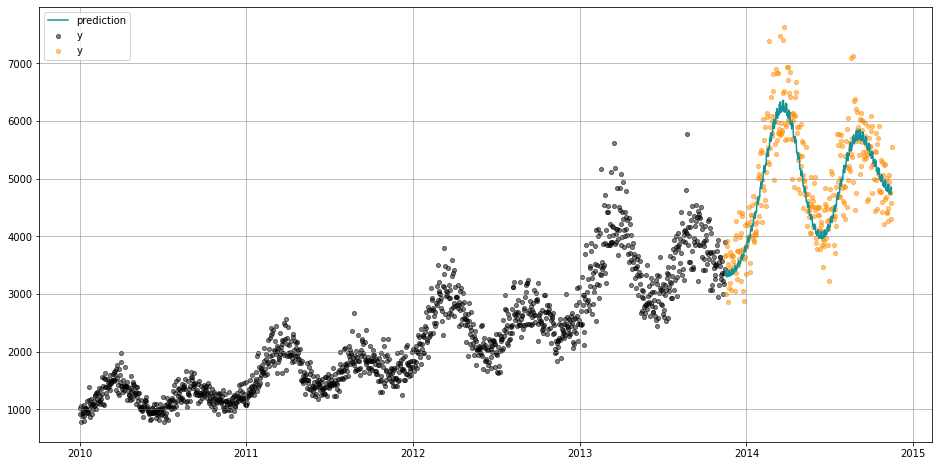

In [32]:
predicted_df = mod.predict(df=test_df)
predicted_df['prediction'] = predicted_df['prediction'].apply(np.exp)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mod.date_col, actual_col=response_col,
                    pred_col='prediction',
                    test_actual_df=test_df)

## Case II - Melbourne, Australia Daily Temperature

We test a popular dataset which describe the log page views from Wikipedia based on [wikipediatrend](https://cran.r-project.org/web/packages/wikipediatrend/index.html).  It is also available from [prophet](https://github.com/facebook/prophet/blob/master/examples/example_wp_log_peyton_manning.csv) 

In [51]:
DATA_FILE = "./data/example_wp_log_peyton_manning.csv"
raw_df = pd.read_csv(DATA_FILE, parse_dates=['ds'])
date_col='ds'
response_col='y'

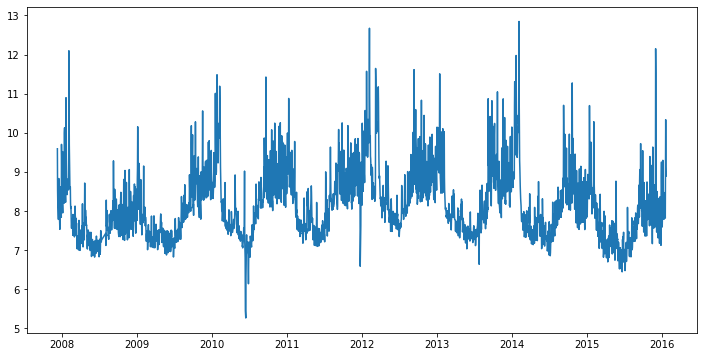

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(raw_df[date_col], raw_df[response_col])

In [53]:
df, fs_cols = fourier_series_df(raw_df, date_col, 365.25, 5)
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

The trend here is relatively stable which challenges the stochastic trend assumption. Fixing a small levels smoothing parameter is a solution. User can also use backtest to search a resaonable value.

In [57]:
mod = DLT(
    response_col='y',
    date_col=date_col,
    infer_method='map',
    predict_method='map',
    seasonality=7,
    regressor_col=fs_cols,
    is_multiplicative=False,
    seed=2020,
    regressor_sigma_prior=[10.0] * len(fs_cols),
    period=365.25,
    level_sm_input=0.001,
)

In [58]:
%%time
mod.fit(df=train_df)

CPU times: user 1.26 s, sys: 24.5 ms, total: 1.29 s
Wall time: 1.31 s


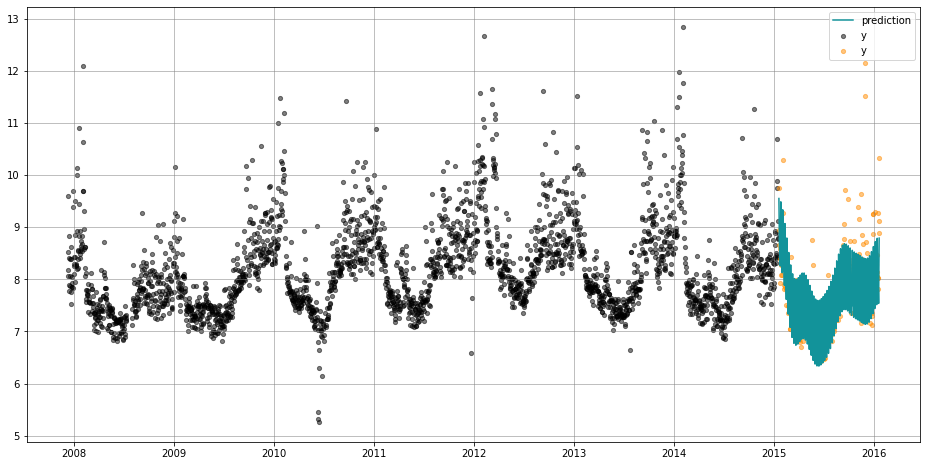

In [59]:
predicted_df = mod.predict(df=test_df)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mod.date_col, actual_col=response_col, 
                    pred_col='prediction',
                    test_actual_df=test_df)